## Part 1
- Overview
- Demo
- Model overview
- Preloaded model & tokenizer
- Quick test

## Part 2
- Update model
- Load dataset
- Data formatting loader

## Part 3
- Training
- Testing
- Recreate demo

# Download Modules

In [1]:
# !pip install transformers sentencepiece datasets

In [2]:
from datasets import load_dataset
# from google.colab import drive
# from IPython.display import display
# from IPython.html import widgets
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import os
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig, AutoModel
from transformers import get_linear_schedule_with_warmup
!jupyter nbextension enable --py widgetsnbextension
from tqdm import notebook
import pandas as pd
import glob2
sns.set()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# drive.mount('/content/gdrive')

In [4]:
model_repo = 'alirezamsh/small100'
model_path = './model/small100_no_pretrained.pt'
model_folder = './model/'
max_seq_len = 128

# Load Tokenizer & Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo, max_new_tokens = max_seq_len)

In [6]:
# Model description: https://huggingface.co/google/mt5-base
config = AutoConfig.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_config(config)
model = model.cuda()


# Overview and Quick Test

In [7]:
token_ids = tokenizer.encode(
    '<lo> This will be translated to Laos! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids, max_new_tokens = max_seq_len)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[128022,   5966,    704,   3473,  36606,  13635,    667,   5815,   2791,
            241,    128,    343,     63,     30,     11,  34023, 120433,   2247,
             17,      2]], device='cuda:0')
tensor([[    2, 23471, 23471, 23471, 23471, 23471, 23471, 23471, 23471, 23471,
         23471, 23471, 23471, 23471, 23471, 23471, 23471,  9646,  9646,  9646,
          9646,  9646,  9646,  9646,  9646,  9646,  9646,  9646,  9646,  9646,
          9646,  9646,  9646,  9646,  9646,  9646,  9646, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
         57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769, 57769,
    

# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [8]:
example_input_str = '<lo> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[128022,   5966,    704,   3473,  36606,    117,   6286,      8,   4183,
            136,   1450,    297,      5,      2]])
Tokens: ['__en__', '▁<', 'lo', '>', '▁This', '▁is', '▁just', '▁a', '▁test', '▁n', 'bu', 'ig', '.', '</s>']


In [9]:
# sorted(tokenizer[], key=lambda x: x[1])
# len(tokenizer.vocab.items())

# Prepare Dataset

## Duolingual Dataset

In [10]:
import glob2
lo_train_filenames = sorted(glob2.glob('./data/train/Nhattan/split/train/*.lo'))
vi_train_filenames = sorted(glob2.glob('./data/train/Nhattan/split/train/*.vi'))
print(lo_train_filenames)
print(vi_train_filenames)
lo_val_filenames = sorted(glob2.glob('./data/train/Nhattan/split/val/*.lo'))
vi_val_filenames = sorted(glob2.glob('./data/train/Nhattan/split/val/*.vi'))
print(lo_val_filenames)
print(vi_val_filenames)

['./data/train/Nhattan/split/train/split_train2023_combine0to40k_basicPreprocessed.lo', './data/train/Nhattan/split/train/split_train2023_combine40kto100k_basicPreprocessed.lo']
['./data/train/Nhattan/split/train/split_train2023_combine0to40k_basicPreprocessed.vi', './data/train/Nhattan/split/train/split_train2023_combine40kto100k_basicPreprocessed.vi']
['./data/train/Nhattan/split/val/split_val2023_0to10k.lo', './data/train/Nhattan/split/val/split_val2023_10kto30k.lo', './data/train/Nhattan/split/val/split_val2023_40kto100k.lo']
['./data/train/Nhattan/split/val/split_val2023_0to10k.vi', './data/train/Nhattan/split/val/split_val2023_10kto30k.vi', './data/train/Nhattan/split/val/split_val2023_40kto100k.vi']


In [11]:
from datasets import load_dataset, Dataset
lo_train_dataset = load_dataset("text", data_files=lo_train_filenames)
vi_train_dataset = load_dataset("text", data_files=vi_train_filenames)
lo_test_dataset = load_dataset("text", data_files=lo_val_filenames)
vi_test_dataset = load_dataset("text", data_files=vi_val_filenames)

Using custom data configuration default-f4a65be3625ba821
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-f4a65be3625ba821/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-643804beb805be1a
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-643804beb805be1a/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-0d944f7a98975e76
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-0d944f7a98975e76/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-f4ec4dbc6f73d858
Found cached dataset text (/home/comrade/.cache/huggingface/datasets/text/default-f4ec4dbc6f73d858/0.0.0/99cc88223027054f94ce0c7fd69d10eb172910fa0615671283a3c8e5e7af2f9c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
lo_train_dataset = lo_train_dataset["train"]['text']
vi_train_dataset = vi_train_dataset["train"]['text']
lo_test_dataset = lo_test_dataset["train"]['text']
vi_test_dataset = vi_test_dataset["train"]['text']

In [13]:
train_dataset = Dataset.from_dict({"translation": Dataset.from_dict({"lo": lo_train_dataset, "vi": vi_train_dataset})})
test_dataset = Dataset.from_dict({"translation": Dataset.from_dict({"lo": lo_test_dataset, "vi": vi_test_dataset})})
# import pandas as pd
# train_dataset = pd.DataFrame(train_dataset['translation']).to_dict(orient="records")
# test_dataset = pd.DataFrame(test_dataset['translation']).to_dict(orient="records")
# train_dataset = Dataset(train_dataset)
# test_dataset = Dataset(test_dataset)

In [14]:
train_dataset['translation'][0:9]

[{'lo': 'ໃນ ຂໍ້ ທີ 33 ເຮົາ ອ່ານ ກ່ຽວ ກັບ ຜູ້ ຄົນ ທີ່ ຕອບ ຮັບອີກ ແບບ ຫນຶ່ງ ກັບ ສຽງຫົວຂວັນ ແລະ ຄໍາ ເຍາະ ເຍີ້ຍ ທີ່ ພວກ ເຂົາ ໄດ້ ຍິນ ຈາກ ອາຄານ ຫລັງນັ້ນ.',
  'vi': 'Trong câu 33 chúng ta đọc về những người đã có phản ứng khác nhau đối với lời nhạo báng và chế nhạo đến từ tòa nhà.'},
 {'lo': 'ສະນັ້ນ ເພິ່ນ ຈຶ່ງ ພະຍາຍາມ ຈົນ ສຸດ ຄວາມ ສາມາດ ເພື່ອ ຈະ ໄດ້ ສະ ແດງ ຄວາມ ສໍາ ເລັດ ຜົນຂອງ ປະ ເທດ.',
  'vi': 'Và do đó, ông đã bỏ ra hết nỗ lực để phô trương những thành tựu của đất nước đó.'},
 {'lo': '15 ຈົ່ງ ເບິ່ງ, ພວກ ເຂົາ ຈະ ຮ່ວມ ກັນ ຕໍ່ສູ້ ເຈົ້າຢ່າງ ແນ່ນອນ, ແຕ່ ບໍ່ ແມ່ນ ໂດຍ ເຮົາ; ຜູ້ ໃດກໍ ຕາມ ທີ່ ຈະ ຮ່ວມ ກັນ ຕໍ່ຕ້ານ ເຈົ້າ ກໍ ຈະລົ້ມລົງ.',
  'vi': '15 Này, chắc chắn sẽ có kẻ tụ họp lập mưu hại ngươi, nhưng việc đó chẳng phải do ta; bất cứ kẻ nào tụ tập nhau lại để hại ngươi cũng sẽ ngã xuống vì cớ ngươi.'},
 {'lo': 'ລະຫວ່າງ ສອງ ປີຜ່ານມາ ນີ້, ໂດຍ ທີ່ ພວກ ເຮົາ ພະຍາຍາມ ເອົາໃຈໃສ່ ກັບ ການ ສ້າງ ພຣະ ວິຫານ ທີ່ ໄດ້ປະກາດ ໄປ ໃຫ້ ສໍາເລັດ, ພວກ ເຮົາ ໄດ້ ງົດ ແຜນທີ່ ຈະ ປະກາດ ພຣະ ວິຫານ ທີ່ ຈະ ສ້າງ ເພີ່ມ ເຕີມ.',
  'vi': '

In [15]:
# LANG_TOKEN_MAPPING = {
#     'vi': '<vi>',
#     'lo': '<lo>'
# }
tokenizer.src_lang = "vi"
tokenizer.tgt_lang = "lo"
sampleInputSentence = 'Phiên dịch tiếng Lào: câu này sẽ được dịch thành tiếng Lào.'
sampleOutputSentence = 'ການ​ແປ​ພາ​ສາ​ລາວ​: ປະ​ໂຫຍກ​ນີ້​ຈະ​ຖືກ​ແປ​ເປັນ​ພາ​ສາ​ລາວ​.'

tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)
print(tokenizerOutput['input_ids'])
print(tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0]))
print(tokenizer.decode(tokenizerOutput['input_ids'][0]))

model.eval()
modelOutput = model(tokenizerOutput['input_ids'],
                    attention_mask = tokenizerOutput['attention_mask'],
                    labels = tokenizerOutput['labels'])

modelGenerate = model.generate(tokenizerOutput['input_ids'], max_new_tokens = max_seq_len, forced_bos_token_id=tokenizer.get_lang_id("lo"))
print(modelGenerate)

output_text = tokenizer.decode(modelGenerate[0])
print(tokenizer.convert_ids_to_tokens(modelGenerate[0]))
print(output_text)

tensor([[128097,  73158,   6152,  13056,  15183,     98,  20232,      9,  25573,
           2752,   3271,   1304,  13056,   4647,  15183,     98,  20232,      5,
              2,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [16]:
tokenizerOutput = tokenizer(
    text = sampleInputSentence,
    text_target = sampleOutputSentence,
    return_tensors = 'pt',
    padding = 'max_length',
    truncation = True,
    max_length = max_seq_len).to(device)

tokens = tokenizer.convert_ids_to_tokens(tokenizerOutput['input_ids'][0])
print(tokens) # Make sure that the special translation token is not 'fragmented'

['__vi__', '▁Phi', 'ên', '▁dịch', '▁tiếng', '▁L', 'ào', ':', '▁câu', '▁này', '▁sẽ', '▁được', '▁dịch', '▁thành', '▁tiếng', '▁L', 'ào', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

In [17]:
# special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
# tokenizer.add_special_tokens(special_tokens_dict)
# model.resize_token_embeddings(len(tokenizer))

In [18]:
# torch.save(model, model_path)

In [19]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[128097,   5966,    704,   3473,  36606,    117,   6286,      8,   4183,
            136,   1450,    297,      5,      2,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [20]:
# # Testing `data_transform`
# in_ids, out_ids, attention_mask = format_translation_data(
#     train_dataset[0]['translation'], tokenizer)

# print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
# print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# # Testing data generator
# data_gen = get_data_generator(train_dataset, tokenizer, 8)
# data_batch = next(data_gen)
# print('Input shape:', data_batch[0].shape)
# print('Output shape:', data_batch[1].shape)
# print('Attention mask shape:', data_batch[2].shape)

# Train/Finetune

In [21]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [22]:
# Constants
n_epochs = 20
# batch_size = 16
batch_size = 24
print_freq = 100
checkpoint_freq = 400
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [23]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [24]:
losses = []

In [25]:
# def eval_model(model, gdataset, max_iters = 16):
    
#     model.eval()
#     test_generator = get_data_generator(gdataset,
#                                       tokenizer, batch_size)
#     eval_losses = []
#     for i, (input_batch, label_batch, attention_mask_batch) in enumerate(test_generator):
#         if i >= max_iters:
#             break
    
#         model_out = model(
#             input_ids = input_batch,
#             labels = label_batch,
#             attention_mask = attention_mask_batch)
#         eval_losses.append(model_out.loss.item())
    
#     return np.mean(eval_losses)

In [26]:
# for epoch_idx in range(n_epochs):
#   # Randomize data order
#   data_generator = get_data_generator(train_dataset,
#                                       tokenizer, batch_size)

#   for batch_idx, (input_batch, label_batch, attention_mask_batch) \
#       in notebook.tqdm(enumerate(data_generator), total=n_batches):
#     optimizer.zero_grad()

#     # Forward pass
#     model_out = model.forward(
#         input_ids = input_batch,
#         labels = label_batch)

#     # Calculate loss and update weights
#     loss = model_out.loss
#     losses.append(loss.item())
#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     # Print training update info
#     if (batch_idx + 1) % print_freq == 0:
#       avg_loss = np.mean(losses[-print_freq:])
#       print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
#           epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

#     if (batch_idx + 1) % checkpoint_freq == 0:
#       test_loss = eval_model(model, test_dataset)
#       print('Saving model with test loss of {:.3f}'.format(test_loss))
#       torch.save(model.state_dict(), model_path)

# torch.save(model.state_dict(), model_path)

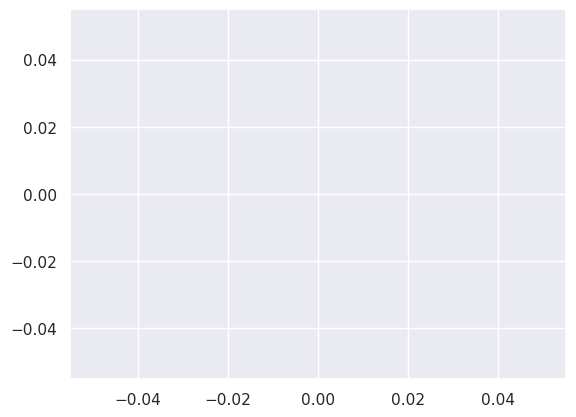

In [27]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [28]:
def encode_str(text, text_target, tokenizer, seq_len):

    # Tokenize and add special tokens
    tokenizerOutp = tokenizer(
        text = text,
        text_target = text_target,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = seq_len).to(device)

    return tokenizerOutp['input_ids'][0], tokenizerOutp['labels'][0], tokenizerOutp['attention_mask'][0]


def format_translation_data(translations, tokenizer, input_lang, target_lang, seq_len = max_seq_len):

    # Get the translations for the batch
    input_text = translations[input_lang]
    target_text = translations[target_lang]

    if input_text is None or target_text is None:
        return None

    if ((input_lang == 'lo') & (target_lang == 'vi')):
        tokenizer.src_lang = "lo"
        tokenizer.tgt_lang = "vi"
    elif ((input_lang == 'vi') & (target_lang == 'lo')):
        tokenizer.src_lang = "vi"
        tokenizer.tgt_lang = "lo"
    else:
        print('WARNING: SOMETHING WRONG WHEN RANDOMIZING LANG')

    input_token_ids, target_token_ids, attention_mask = encode_str(
        input_text, target_text, tokenizer, seq_len)

    return input_token_ids, target_token_ids, attention_mask


def transform_batch(batch, tokenizer, input_lang, target_lang):
    inputs = []
    targets = []
    attentionMask = []
    for translation_set in batch['translation']:
        formatted_data = format_translation_data(
            translation_set, tokenizer, input_lang, target_lang, max_seq_len)

        if formatted_data is None:
            continue

        input_ids, target_ids, attention_mask = formatted_data

        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))
        attentionMask.append(attention_mask.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()
    attentionMask = torch.cat(attentionMask).cuda()

    return batch_input_ids, batch_target_ids, attentionMask


def get_data_generator(dataset, input_lang, target_lang, tokenizer, batch_size = 256):
    dataset = dataset.shuffle()
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_batch(raw_batch, tokenizer, input_lang, target_lang)

In [47]:
def eval_model(model, tokenizer, gdataset, input_lang = 'lo', target_lang = 'vi'):

    model.eval()
    test_generator = get_data_generator(gdataset, input_lang, target_lang, tokenizer, batch_size = 32)

    trueSentenceListLoVi = []
    outputSentenceListLoVi = []

    trueSentenceListViLo = []
    outputSentenceListViLo = []

    for i, (input_batch, label_batch, attention_mask_batch) in enumerate(test_generator):
        print(i)
        outpSentenceLoVi = model.generate(input_batch, num_beams = 1, num_return_sequences=1, max_new_tokens = max_seq_len, forced_bos_token_id = tokenizer.get_lang_id(target_lang))
        outpSentenceLoVi = tokenizer.batch_decode(outpSentenceLoVi, skip_special_tokens = True)
        outputSentenceListLoVi = outputSentenceListLoVi + outpSentenceLoVi

        trueSentenceLoVi = tokenizer.batch_decode(label_batch, skip_special_tokens = True)
        trueSentenceListLoVi = trueSentenceListLoVi + trueSentenceLoVi


        outpSentenceViLo = model.generate(label_batch, num_beams = 1, num_return_sequences=1, max_new_tokens = max_seq_len, forced_bos_token_id = tokenizer.get_lang_id(input_lang))
        outpSentenceViLo = tokenizer.batch_decode(outpSentenceViLo, skip_special_tokens = True)
        outputSentenceListViLo = outputSentenceListViLo + outpSentenceViLo

        trueSentenceViLo = tokenizer.batch_decode(input_batch, skip_special_tokens = True)
        trueSentenceListViLo = trueSentenceListViLo + trueSentenceViLo
        

    print(len(trueSentenceListLoVi))
    print(len(outputSentenceListLoVi))
    print(len(trueSentenceListViLo))
    print(len(outputSentenceListViLo))

    return (trueSentenceListLoVi, outputSentenceListLoVi, trueSentenceListViLo, outputSentenceListViLo)

In [48]:
trueSentenceListLoVi, outputSentenceListLoVi, trueSentenceListViLo, outputSentenceListViLo = eval_model(model, tokenizer, test_dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
import json

with open("outputSentenceListLoVi.json", 'w') as f:
    json.dump(outputSentenceListLoVi, f, indent = 2, ensure_ascii = False)

with open("outputSentenceListViLo.json", 'w') as f:
    json.dump(outputSentenceListViLo, f, indent = 2, ensure_ascii = False)

with open("trueSentenceListLoVi.json", 'w') as f:
    json.dump(trueSentenceListLoVi, f, indent = 2, ensure_ascii = False)

with open("trueSentenceListViLo.json", 'w') as f:
    json.dump(trueSentenceListViLo, f, indent = 2, ensure_ascii = False)

# Manual Testing

In [ ]:
# test_sentence = test_dataset[0]['translation']['vi']
# print('Raw input text:', test_sentence)

# input_ids = encode_str(
#     text = test_sentence,
#     text_target = 'lo',
#     tokenizer = tokenizer,
#     # seq_len = model.config.max_length,
#     seq_len = max_seq_len,
# )
# input_ids = input_ids.unsqueeze(0).cuda()

# print('Truncated input text:', tokenizer.convert_tokens_to_string(
#     tokenizer.convert_ids_to_tokens(input_ids[0])))

In [34]:
testSrc = 'lo'
testTgt = 'vi'
test_sentence = test_dataset[9]['translation'][testSrc]
test_sentence_target = test_dataset[9]['translation'][testTgt]
print('Raw input text:', test_sentence)

tokenizer.src_lang = testSrc
tokenizer.tgt_lang = testTgt
input_ids, _, _ = encode_str(
    text = test_sentence,
    text_target = test_sentence_target,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: ການ ອອກ ກໍາລັງ ກາຍ ແລະ ກິນ ອາຫານ ທີ່ ມີ ຄຸນຄ່າ ຈະ ທົດ ແທນ ພະລັງ ງານ ທີ່ ສູນ ເສຍ ໄປ ເຊິ່ງ ເປັນ ຜົນ ມາ ຈາກ ຄວາມ ໂສກ ເສົ້າ ເສຍໃຈ ເນື່ອງ ຈາກ ການ ຍຸດຕິ ສາຍ ສໍາພັນ.
Truncated input text: __lo__ ການ ອອກ ກໍາລັງ ກາຍ ແລະ ກິນ ອາຫານ ທີ່ ມີ ຄຸນຄ່າ ຈະ ທົດ ແທນ ພະລັງ ງານ ທີ່ ສູນ ເສຍ ໄປ ເຊິ່ງ ເປັນ ຜົນ ມາ ຈາກ ຄວາມ ໂສກ ເສົ້າ ເສຍໃຈ ເນື່ອງ ຈາກ ການ ຍຸດຕິ ສາຍ ສໍາພັນ.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
# output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens = max_seq_len)
# # print(output_tokens)
# for token_set in output_tokens:
#   print(tokenizer.decode(token_set, skip_special_tokens=True))

In [35]:
output_tokens = model.generate(input_ids, num_beams = 20, num_return_sequences=3, max_new_tokens = max_seq_len, forced_bos_token_id = tokenizer.get_lang_id(testTgt))
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))





































Việc phân chia hàng hóa và giá trị sẽ có mức độ tin cậy, đặc biệt là giai đoạn chuẩn. Sự hy sinh đã được báo cáo trong thời đại kỹ thuật số cũng có thể ảnh hưởng đến ước muốn được sự hiểu biết sâu sắc hơn về thiêng liêng liêng của sự hiểu biết sâu sắc. Sự hiểu biết sâu sắc hơn về thiêng liêng của sự ước tính về mặt đạo đức khi thịnh vĩnh cửu.
Việc phân chia hàng hóa và giá trị sẽ có mức độ tin cậy, đặc biệt là giai đoạn chuẩn. Sự hy sinh đã được báo cáo trong thời đại kỹ thuật số cũng có thể ảnh hưởng đến ước muốn được sự hiểu biết sâu sắc hơn về thiêng liêng liêng của sự hiểu biết sâu sắc. Sự hiểu biết sâu sắc hơn về sự hiểu biết về sự thờ phượng thanh thản.
Việc phân chia hàng hóa và giá trị sẽ có mức độ tin cậy, đặc biệt là giai đoạn chuẩn. Sự hy sinh đã được báo cáo trong thời đại kỹ thuật số cũng có thể ảnh hưởng đến ước muốn được sự hiểu biết sâu sắc hơn về thiêng liêng liêng của sự hiểu biết sâu sắc. Sự hiểu biết sâu sắc hơn về thiêng liêng của sự hiểu biết về sự thờ phượng than

In [38]:
def encode_str(text, text_target, tokenizer, seq_len):

    # Tokenize and add special tokens
    tokenizerOutp = tokenizer(
        text = text,
        text_target = text_target,
        return_tensors = 'pt',
        padding = 'max_length',
        truncation = True,
        max_length = seq_len).to(device)

    return tokenizerOutp['input_ids'][0], tokenizerOutp['labels'][0], tokenizerOutp['attention_mask'][0]

In [45]:
#@title Slick Blue Translate
input_text = input() #@param {type:"string"}
input_language = input()
output_language = input() #@param ["en", "ja", "zh"]

tokenizer.src_lang = input_language
tokenizer.trg_lang = output_language
input_ids = encode_str(
    text = input_text,
    text_target = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    )[0]
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2, max_new_tokens = max_seq_len)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

 một người lướt sóng bị cá mập cắn
 vi
 lo


một người lướt sóng bị cá mập cắn  ->  ມະນຸດ ທໍາ ມະດາ ເຊິ່ງ ສັດ ມາ ຈາກ ດິນ ທີ່ ສວຍ ງາມ
